In [28]:
import os
from collections import  Counter

from tqdm import tqdm
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap

pd.options.display.max_rows = 100000
pd.options.display.max_colwidth = 10000000

# Load dataset

In [2]:
DATA_DIR = "./data"
TRAIN_PATH = os.path.join(DATA_DIR, "eng.testa")
TEST_PATH = os.path.join(DATA_DIR, "eng.train")

In [3]:
!bash ./load_conll_2003.sh --DATA_DIR="$DATA_DIR" --TRAIN_PATH="$TRAIN_PATH" --TEST_PATH="$TEST_PATH"

# Read Dataset

In [4]:
def read_data(file):
    lines = open(file, "r").readlines()
    data = {"sentences": [], "labels_per_sent": []}
    sentence, labels = [], []

    for line in tqdm(lines):
        line = line.strip()

        if not line:
            if sentence and labels:
                assert len(sentence) == len(labels)
                data["sentences"].append(" ".join(sentence))
                data["labels_per_sent"].append(" ".join(labels))
                sentence, labels = [], []
            continue

        if line.startswith("-DOCSTART-"):
            continue
        else:
            values = line.split(" ")
            try:
                token, _, _, label = values
                sentence.append(token)
                # if label != "O":
                #     labels.append(label.split("-")[-1])
                # else:
                labels.append(label)

            except Exception as e:
                print(f"Error has occur: {e}")
                continue
    return data

In [5]:
train = read_data(TRAIN_PATH)
valid = read_data(TEST_PATH)

100%|██████████| 55045/55045 [00:00<00:00, 1514642.64it/s]


In [6]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(valid)

# EDA

In [7]:
df_train.head()

sentences  \
0                                                                                                                                                                       EU rejects German call to boycott British lamb .   
1                                                                                                                                                                                                        Peter Blackburn   
2                                                                                                                                                                                                    BRUSSELS 1996-08-22   
3                            The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .   
4  Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .   

                                                                         labels_per_sent  
0                                                        I-ORG O I-MISC O O O I-MISC O O  
1                                                                            I-PER I-PER  
2                                                                                I-LOC O  
3          O I-ORG I-ORG O O O O O O I-MISC O O O O O I-MISC O O O O O O O O O O O O O O  
4  I-LOC O O O O I-ORG I-ORG O O O I-PER I-PER O O O O O O O O O O O I-LOC O O O O O O O

In [8]:
df_test.head()

sentences  \
0                                                                                                                                                        CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .   
1                                                                                                                                                                                                        LONDON 1996-08-30   
2                              West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .   
3           Their stay on top , though , may be short-lived as title rivals Essex , Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire .   
4  After bowling Somerset out for 83 on the opening morning at Grace Road , Leicestershire extended their first innings by 94 runs before being bowled out for 296 with England discard Andy Caddick taking three for 83 .   

                                                                                           labels_per_sent  
0                                                                                O O I-ORG O O O O O O O O  
1                                                                                                  I-LOC O  
2          I-MISC I-MISC O I-PER I-PER O O O O O O O I-ORG O I-ORG O O O O O O O O O O O O O O O O O O O O  
3            O O O O O O O O O O O O O I-ORG O I-ORG O I-ORG O O O O O O I-ORG O O O O O O O O O O I-ORG O  
4  O O I-ORG O O O O O O O O I-LOC I-LOC O I-ORG O O O O O O O O O O O O O O I-LOC O I-PER I-PER O O O O O

In [9]:
# descriptive statistics
profile = ProfileReport(df_train, config_file="cfg.yml")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# descriptive statistics
profile = ProfileReport(df_test, config_file="cfg.yml")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Распределение между спанами тестового и тренировочного набора схожее
- B-спаны не рассматриваем, так как их мало размечено
- Много дубликатов, желательно почистить

In [11]:
def plot_top_words_barchart(df: pd.Series, not_stopwords: bool = True):
    stop = set(stopwords.words("english"))

    new = df.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most:
        if not_stopwords and word not in stop or not not_stopwords and word in stop:
            x.append(word)
            y.append(count)
        if len(x) > 19:
            break

    sns.barplot(x=y, y=x)


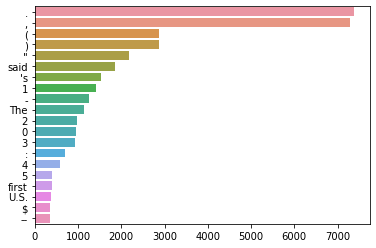

In [12]:
%matplotlib inline
plot_top_words_barchart(df_train["sentences"])

- многое будет завязываться на цифрах

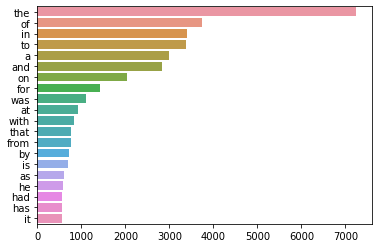

In [13]:
%matplotlib inline
plot_top_words_barchart(df_train["sentences"], not_stopwords=False)

<AxesSubplot:>

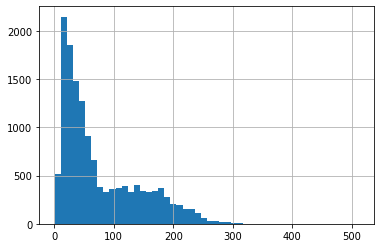

In [14]:
%matplotlib inline
df_train['sentences'].str.len().hist(bins=50)

- Преобладающее большинство примеров довольно короткое по длинне. Ограничено 512 символами.

<AxesSubplot:>

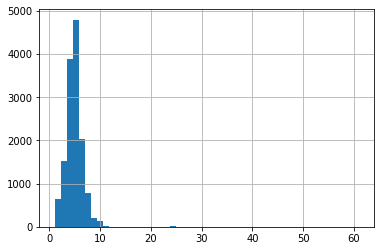

In [15]:
%matplotlib inline
stopwords_set = set(stopwords.words("english"))
df_train['sentences'].str.split().apply(lambda x : [len(i) for i in x if i not in stopwords_set]).map(lambda x: np.mean(x)).hist(bins=50)

- Большая часть слов короткая. Вопрос как хорошо тут контекстно будет обучаться.

In [16]:
def get_spine(df: pd.DataFrame, tag_target: str):
    words = []
    for i, line in df.iterrows():
        ADD = False
        spine = []

        for word, tag in zip(line["sentences"].split(), line["labels_per_sent"].split()):
            if tag == tag_target:
                spine.append(word)
                ADD = True
            else:
                if ADD == True:
                    words.append(" ".join(spine))
                    spine = []
                ADD = False
    
    return Counter(words)

In [17]:
org_spines_counter = get_spine(df_train, "I-ORG")
for i, (k, v) in enumerate(org_spines_counter.items()):
    print(k, v)
    if i > 20:
        break

EU 22
European Commission 7
European Union 20
Commission 11
Welsh National Farmers ' Union 1
NFU 1
BBC radio 2
Foreign Ministry 8
Reuters 73
People 's Daily 2
Shen 1
Reuters Television 1
Xinhua 4
Association for Relations Across the Taiwan Straits 1
Federal office for motor vehicles 1
Volkswagen AG 3
Opel AG 1
General Motors 1
Ford 5
Seat 2
Porsche 2
Athens Newsroom 7


In [18]:
sorted([_ for _ in org_spines_counter.keys()])[:20]

[', Inc.',
 '1860 Munich',
 '2000 Games',
 '3',
 '3M',
 'A.G. Edwards & Sons , Inc',
 'A.S. Bacau',
 'ABC',
 'ABC News',
 'ABERDEEN',
 'ABN AMRO',
 'ABN-AMRO Hoare Govett',
 'AC Milan',
 'AC Sparta Praha',
 'ACC',
 'ACES',
 'AD',
 'ADV',
 'AEI',
 'AEI Iberfreight']

In [19]:
def get_top_ngram(corpus, n: int = 3, length: int = 10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:length]

<AxesSubplot:>

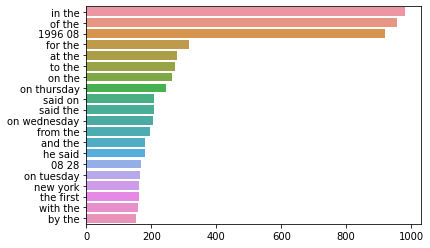

In [20]:
%matplotlib inline
top_tri_grams = get_top_ngram(df_train["sentences"], n=2, length=20)
x, y = map(list, zip(*top_tri_grams))
sns.barplot(x=y, y=x)

<AxesSubplot:>

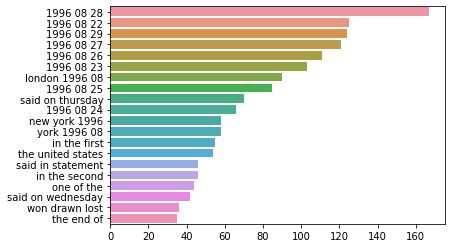

In [21]:
%matplotlib inline
top_tri_grams = get_top_ngram(df_train["sentences"], n=3, length=20)
x, y = map(list, zip(*top_tri_grams))
sns.barplot(x=y, y=x)

In [22]:
def get_words_dataset(df: pd.DataFrame, unic: bool = False):
    words = []
    tags = []
    for i, line in df.iterrows():
        ADD = False
        spine = []

        for word, tag in zip(line["sentences"].split(), line["labels_per_sent"].split()):
            if not unic or word not in words:
                words.append(word)
                tags.append(tag)
    
    return words, tags

In [23]:
def train_rf(unic: bool = False):
    x_train, y_train = get_words_dataset(df_train, unic=unic)
    x_test, y_test = get_words_dataset(df_test, unic=unic)

    vectorizer = CountVectorizer()
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)

    x_train = pd.DataFrame(x_train.toarray(), columns=vectorizer.get_feature_names_out())
    x_test = pd.DataFrame(x_test.toarray(), columns=vectorizer.get_feature_names_out())

    model = RandomForestClassifier(n_estimators=10, n_jobs=-1)
    model.fit(x_train, y_train)

    test_predictions = model.predict(x_test)
    report = classification_report(y_pred=test_predictions, y_true=y_test)
    print(report)

    return x_train, y_train, x_test, y_test, model, vectorizer

In [24]:
# With identical utterances:
# x_train, y_train, x_test, y_test, model, vectorizer = train_rf(unic=False)

# RAM issue

In [25]:
# With identical utterances:
x_train, y_train, x_test, y_test, model, vectorizer = train_rf(unic=True)

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
      B-MISC       0.00      0.00      0.00         2
       I-LOC       0.75      0.57      0.65       499
      I-MISC       0.69      0.43      0.53       354
       I-ORG       0.64      0.48      0.55       714
       I-PER       0.93      0.49      0.64      1634
           O       0.82      0.97      0.89      6763

    accuracy                           0.81      9966
   macro avg       0.55      0.42      0.46      9966
weighted avg       0.82      0.81      0.80      9966



/home/artem/anaconda3/envs/flair/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/artem/anaconda3/envs/flair/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/artem/anaconda3/envs/flair/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
I = pd.DataFrame()

I['Feature'] = x_train.columns
I['Importance'] = model.feature_importances_

I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')

I.head(30)

Importance
Feature               
000           0.001711
10            0.001404
based         0.001220
12            0.001079
00            0.001071
al            0.000824
13            0.000805
15            0.000803
11            0.000797
50            0.000775
year          0.000734
20            0.000702
jean          0.000672
republican    0.000654
soviet        0.000628
16            0.000563
russian       0.000528
amsterdam     0.000486
38            0.000482
india         0.000465
led           0.000445
24            0.000440
british       0.000437
winners       0.000433
14            0.000431
tutsi         0.000429
serb          0.000428
israeli       0.000426
france        0.000426
kabul         0.000420